You are given an images of potato plants exhibiting various diseases, including early blight, late blight, and healthy leaves. Yor tasks are:

- Create a Convolutional Neural Network (CNN) model that can classify the images to specific class.

- Create a custom Dataset class to efficiently load and prepare the data.

- Clearly define the architecture of your CNN model, specifying the number of layers, neurons, and activation functions.
- Make two version of your model with different number of layers and hidden neurons
- Train the model on the prepared data and evaluate its performance on a separate validation set.
- Track the training loss during training and plot it to visualize the learning process.

- Print some sample predictions from the trained model to demonstrate its capabilities.



 Dataset:
https://www.kaggle.com/datasets/hafiznouman786/potato-plant-diseases-data

In [1]:
from IPython.display import clear_output

In [2]:
!pip install opendatasets
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download hafiznouman786/potato-plant-diseases-data
!unzip /content/potato-plant-diseases-data.zip
clear_output()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models,transforms
from torchvision.utils import make_grid
import os
import glob
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

In [9]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # Get the folder names and sort them
        self.image_paths = []
        self.labels = []

        # Iterate through each class directory and collect image paths and labels
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_path in glob.glob(os.path.join(class_dir, '*')):
                self.image_paths.append(img_path)
                self.labels.append(label)

        # Shuffle the dataset
        combined = list(zip(self.image_paths, self.labels))
        random.shuffle(combined)
        self.image_paths[:], self.labels[:] = zip(*combined)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = CustomDataset(root_dir='/content/PotatoPlants', transform=transform)

In [12]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [18]:
train_dataset[0][0].shape

torch.Size([3, 256, 256])

In [13]:
b_size = 32
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
val_loader =   DataLoader(val_dataset, batch_size=b_size)
test_loader =  DataLoader(test_dataset, batch_size=b_size)

In [21]:
class CNN(nn.Module):

  def __init__(self, input_ch, num_class):
    super().__init__()
    self.conv1 = nn.Conv2d(input_ch,20, 3, 1, 1) #(input channels, output channels, size (height and width) of the convolutional kernel, stride, padding)
    self.conv2 = nn.Conv2d(20, 50, 3, 1, 1)
    self.fc1 = nn.Linear(50 * 64 * 64, 100)
    self.fc2 = nn.Linear(100,num_class)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    #feature extractor
    #x--->(1, 256,256)
    x = self.conv1(x)
    x1 = self.relu(x)

    #x---->(1,256,256)
    x = self.pool(x1)

    #x---->(10, 128, 128)
    x = self.conv2(x)
    x2 = self.relu(x)

    #x---->(50, 128,128)
    x = self.pool(x2)

    #x---->(50,64,64)
    x = x.view(-1,50 * 64 * 64)

    #classifier
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

learning_rate = 0.001
num_epochs = 10
input_dim = 3
num_class =3

model = CNN(input_dim, num_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
# Training loop
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    training_accuracy = 100 * correct / total

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_dataset)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f} - Train Accuracy: {training_accuracy:.2f}% - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.2f}%')

Epoch 1/10, Train Loss: 0.8545 - Train Accuracy: 78.73% - Val Loss: 0.2203 - Val Accuracy: 90.70%
Epoch 2/10, Train Loss: 0.1921 - Train Accuracy: 92.91% - Val Loss: 0.2728 - Val Accuracy: 89.30%
Epoch 3/10, Train Loss: 0.0923 - Train Accuracy: 97.15% - Val Loss: 0.2115 - Val Accuracy: 93.02%
Epoch 4/10, Train Loss: 0.0719 - Train Accuracy: 97.56% - Val Loss: 0.3559 - Val Accuracy: 88.84%
Epoch 5/10, Train Loss: 0.0565 - Train Accuracy: 97.73% - Val Loss: 0.1131 - Val Accuracy: 95.35%
Epoch 6/10, Train Loss: 0.0240 - Train Accuracy: 99.24% - Val Loss: 0.1857 - Val Accuracy: 93.49%
Epoch 7/10, Train Loss: 0.0105 - Train Accuracy: 99.88% - Val Loss: 0.1961 - Val Accuracy: 94.42%
Epoch 8/10, Train Loss: 0.0115 - Train Accuracy: 99.83% - Val Loss: 0.1428 - Val Accuracy: 95.81%
Epoch 9/10, Train Loss: 0.0029 - Train Accuracy: 100.00% - Val Loss: 0.2035 - Val Accuracy: 94.42%
Epoch 10/10, Train Loss: 0.0012 - Train Accuracy: 100.00% - Val Loss: 0.1623 - Val Accuracy: 95.35%


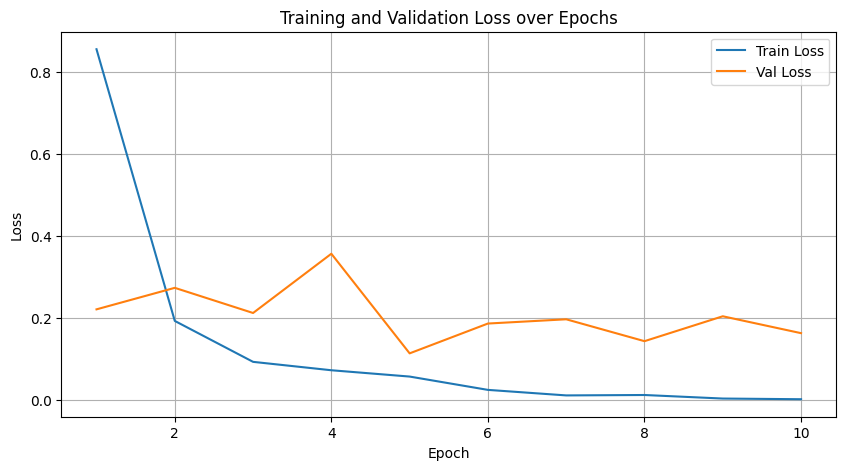

In [24]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.title(f'Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Test the model
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_dataset)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.0807, Test Accuracy: 98.15%


In [26]:
# Example: Load a batch from DataLoader
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
# Example: Apply model to batch of images
outputs = model(images)
_, predicted = torch.max(outputs.data, 1)  # Get the index of the class with the highest probability
# Convert tensors to numpy arrays for plotting
images_np = images.cpu().numpy()
labels_true = labels.numpy()
labels_pred = predicted.cpu().numpy()

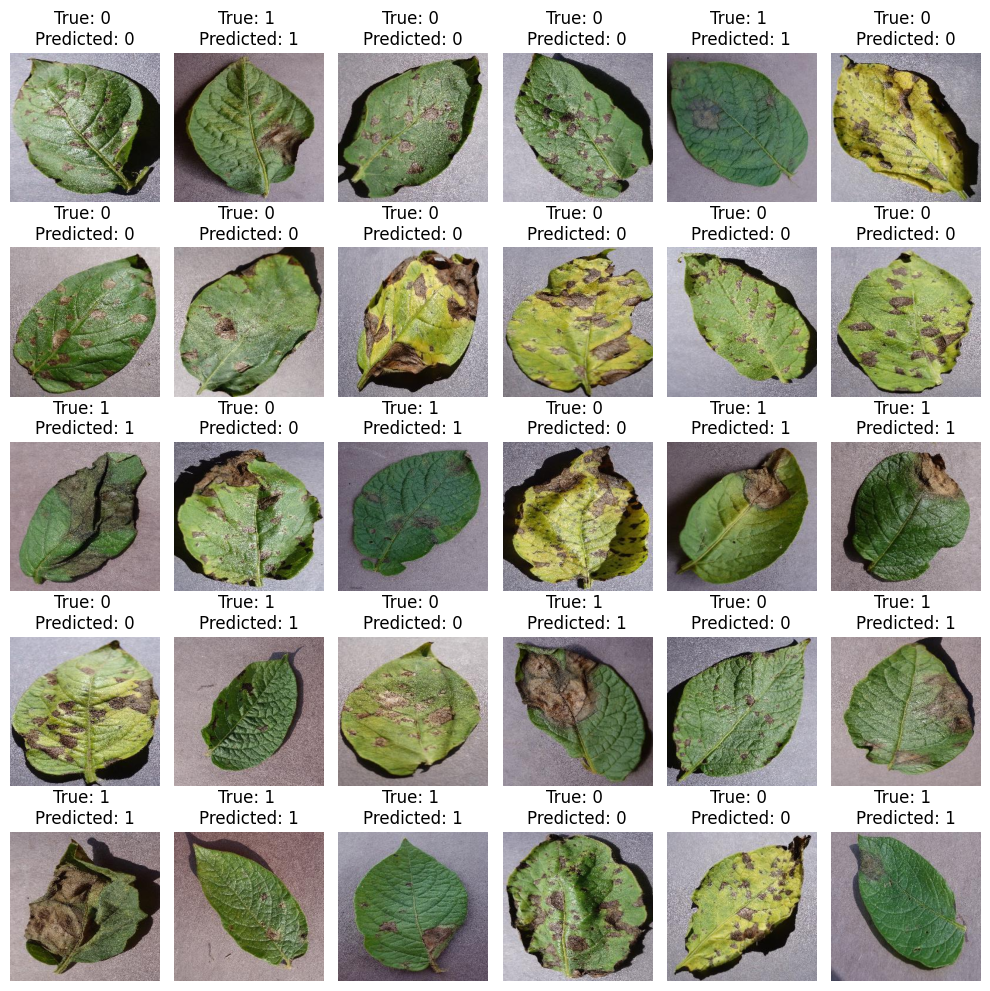

In [27]:
# Create a grid of images
num_images = len(images_np)
rows = int(np.sqrt(num_images))
cols = num_images // rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

if labels_pred is None:
    labels_pred = labels_true

for i, ax in enumerate(axes.flat):
    # Plot image
    ax.imshow(np.transpose(images_np[i], (1, 2, 0)), cmap='gray')
    ax.axis('off')

    # Show true and predicted labels
    ax_title = f"True: {labels_true[i]} \nPredicted: {labels_pred[i]}"
    ax.set_title(ax_title)

plt.tight_layout()
plt.show()